In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.stattools import medcouple
from scipy.optimize import newton
from scipy.special import digamma
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.utility_functions as ut
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex


# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

# name of the output folder:
name_of_project = 'threshold_values'

# the scale for pieces per meter and the column and chart label for the units
reporting_unit = 100
unit_label = 'p/100m'

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# get your data:
survey_data = pd.read_csv('resources/results_with_land_use_2015.csv')
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/dims_data.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# map water_name_slug to water_name
wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True).drop_duplicates()
wname_wname.set_index('water_name_slug', inplace=True)

# convenience function for doing land use correlations
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    return ax, corr, a_p

# index the code data
dfCodes.set_index("code", inplace=True)

# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation: includes spray foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/tampons, applicators"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)
dfCodes = sut.shorten_the_value(["G82", "description", "Expanded foams 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G81", "description", "Expanded foams .5cm - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G117", "description", "Expanded foams < 5mm"], dfCodes)
dfCodes = sut.shorten_the_value(["G75", "description", "Plastic/foamed polystyrene 0 - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G76", "description", "Plastic/foamed polystyrene 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G24", "description", "Plastic lid rings"], dfCodes)
dfCodes = sut.shorten_the_value(["G33", "description", "Lids for togo drinks plastic"], dfCodes)
dfCodes = sut.shorten_the_value(["G3", "description", "Plastic bags, carier bags"], dfCodes)
dfCodes = sut.shorten_the_value(["G204", "description", "Bricks, pipes not plastic"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

(threshhold)=
# Beach litter baselines

Baseline values (BVs), sometimes referred to as _benchmarks_, are the quantities or values that are used to define a situation statistically. The BVs refer to a set of data that has both temporal and geographical limits, sometimes referred to as a *reference point* or *baseline period*, BVs are the quantities against which progress is measured. In this regard, BVs are intimately linked to the data and the methods used to collect
it.

## Counting beach litter: an overview

The first international guide to collecting beach-litter data was published in 2008 by the United Nations Environment Programme (UNEP)
and Intergovernmental Oceanographic Commission (IOC) {cite}`unepseas`. Based on the accumulated work of many scientists, this method was
reproduced by the OSPAR Commission in 2010 {cite}`ospard10`, and in 2013 the EU released _Guidance on Monitoring of Marine Litter in European Seas_ (_the guide_) {cite}`mlwguidance`. Switzerland is a member of OSPAR and has over 1,500 samples using the methods described in _the guide_.

_The guide_ was followed by _Riverine Litter Monitoring - Options and Recommendations_ in 2016 {cite}`riverinemonitor`, reflecting the mounting evidence that rivers are important sources of household waste in coastal regions. By that time the initial beach litter surveillance project on Lac Léman had run its course and preparations were on the way for a year long national project in Switzerland initiated by STOPPP and supported by WWF volunteers, see [_More and less trash since 2017_](slr-iqaasl).

In 2019 the Joint Research Centre (JRC) released an _Analysis of a pan-European 2012-2016 beach litter dataset_ , a technical document that detailed the methods and different scenarios for calculating baseline values from beach litter data. Of particular interest to the JRC was the robustness of methods to extreme values and transparency of the calculation method. {cite}`eubaselines`

Finally, in September 2020 the EU established baseline and target values based on the data collected from 2015-2016. The target values relate to the Good Environmental Status of marine waters described by the Marine Strategy Framework Directive (MSFD) and the baselines were calculated using the methods described in the 2019 publication. {cite}`threshholdeu`

### Switzerland 2020

The IQAASL project started in April 2020, recycling many of the locations sampled in 2017 and establishing new locations throughout the defined survey areas. Similar to survey results in the marine environment beach-litter-data in Switzerland is highly variable. With values ranging from zero to thousands of objects and fragments within 100m of river or lake shoreline.

## Calculating baselines

The methods described in sections 3 and 4 of _A European Threshold Value and Assessment Method for Macro Litter on Coastlines_ and sections 6, 7 and 8 from _Analysis of a pan-European 2012-2016 beach litter dataset_  are applied to the beach litter survey results from April 2020 to May 2021.

The different options for calculating baselines, determining confidence intervals and identifying extreme values are explained and examples are given.

__Assumptions:__

*  The more trash there is on the ground the more a person is likely to find
*  **The survey results represent the minimum amount of trash at that site**
*  For each survey: finding one item does not effect the chance of finding another

### The data

Only surveys with a length greater than ten meters and less than 100 meters are included in the baseline calculation. The following objects were excluded:

1. Objects less than 2.5cm
2. Paraffin, wax, oil and other pollutants



In [2]:
# define the final survey data set here:
a_data = survey_data.copy()

# make a loc_date column from the survey data
# before converting to timestamp
a_data['loc_date']=tuple(zip(a_data.location, a_data.date))

# convert string dates from .csv to timestamp
a_data['date']=pd.to_datetime(a_data['date'], format='%Y-%m-%d')

# slice by start - end date
a_data = a_data[(a_data.date >= start_date)&(a_data.date <= end_date)]

# combine lugano and maggiore
# if the river bassin name does not equal tresa leave it, else change it to ticino
a_data['river_bassin'] = a_data.river_bassin.where(a_data.river_bassin != 'tresa', 'ticino' )

# assign the reporting value
a_data[unit_label] = (a_data.pcs_m * reporting_unit).round(2)

# scale the streets to kilometers
a_data['streets'] = a_data.streets.astype('int')
a_data['streets km'] = a_data.streets/1000

# save the data before aggregating to test
before_agg = a_data.copy()

# !! Remove the objects less than 2.5cm and chemicals !!
codes_todrop = ['G81', 'G78', 'G212', 'G213', 'G214']
a_data = a_data[~a_data.code.isin(codes_todrop)]

# use the code groups to get rid of all objects less than 5mm
a_data = a_data[a_data.groupname !=  'micro plastics (< 5mm)']
# !! 

# match records to survey data
fd_dims= dfDims[(dfDims.location.isin(a_data.location.unique()))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# make a loc_date column and get the unique values
fd_dims['loc_date'] = list(zip(fd_dims.location, fd_dims.date))

# map the survey area name to the dims data record
a_map = fd_dims[['loc_date', 'area']].set_index('loc_date')
l_map = fd_dims[['loc_date', 'length']].set_index('loc_date')

# map length and area from dims to survey data
for a_survey in fd_dims.loc_date.unique():
    a_data.loc[a_data.loc_date == a_survey, 'length'] = l_map.loc[[a_survey], 'length'][0]
    a_data.loc[a_data.loc_date == a_survey, 'area'] = a_map.loc[[a_survey], 'area'][0]

# exclude surveys less 10 meters or less
gten_lhun = a_data.loc[(a_data.length > 10)].copy()

# this is a common aggregation
agg_pcs_quantity = {unit_label:'sum', 'quantity':'sum'}

# survey totals by location
dt_all = gten_lhun.groupby(['loc_date','location','river_bassin', 'water_name_slug','date'], as_index=False).agg(agg_pcs_quantity)

*Survey results and summary statistics: samples greater than 10m and excluding objects less than 2.5cm and chemicals, n=371*

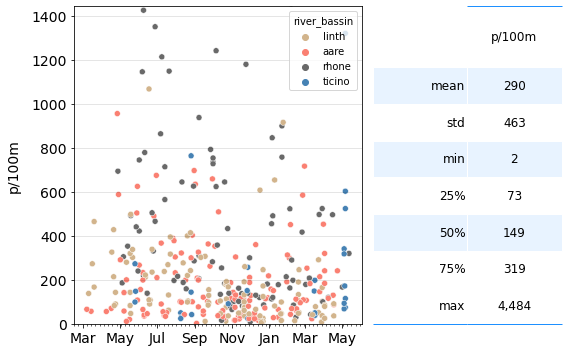

In [3]:
# palettes and labels
bassin_pallette = {'rhone':'dimgray', 'aare':'salmon', 'linth':'tan', 'ticino':'steelblue', 'reuss':'purple'}
comp_labels = {"linth":"Linth/Limmat", "rhone":"Rhône", 'aare':"Aare", "ticino":"Ticino/Cerisio", "reuss":"Reuss"}
comp_palette = {"Linth/Limmat":"dimgray", "Rhône":"tan", "Aare":"salmon", "Ticino/Cerisio":"steelblue", "Reuss":"purple"}

# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)

# sns.set_style('whitegrid')

fig = plt.figure(figsize=(8,5))

gs = GridSpec(1,5)

ax = fig.add_subplot(gs[:,0:3])
axtwo = fig.add_subplot(gs[:, 3:])

# scale the chart as needed to accomodate for extreme values
scale_back = 98

# the results gets applied to the y_limit function in the chart
the_90th = np.percentile(dt_all[unit_label], scale_back)

# the survey totals
sns.scatterplot(data=dt_all, x='date', y=unit_label, hue='river_bassin', palette=bassin_pallette, alpha=1, ax=ax)

# set params on ax:
ax.set_ylim(0,the_90th )
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)

# axtwo
a_color = "dodgerblue"

# summarize the survey totals and format for printing
table_data = dt_all[unit_label].describe()
table_data.drop('count', inplace=True)
table_data = table_data.astype('int')
table_data = table_data.map(lambda x: "{:,}".format(x))

# make a 2d array
t_data = list(zip(table_data.index, table_data.values))

data = t_data

ut.hide_spines_ticks_grids(axtwo)

the_first_table_data = axtwo.table(data,  colLabels=["Stat", unit_label], colWidths=[.5,.5], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data,["Stat", unit_label], a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")
axtwo.tick_params(which='both', axis='both', labelsize=14)
ax.tick_params(which='both', axis='both', labelsize=14)
ax.grid(b=True, which='major', axis='y', linestyle='-', linewidth=1, c='black', alpha=.1, zorder=0)

plt.tight_layout()
plt.show()
plt.close()

*Distribution of surveys and percentile ranking values: all surveys. Note the mean (290p/100m) is greater than the median (149p/100m)*

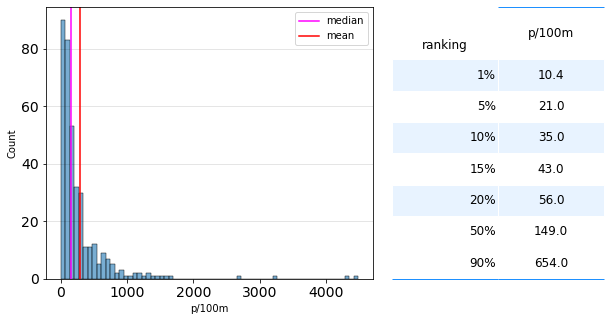

In [4]:
# percentile rankings  1, 5, 10, 15, 20
these_vals = []
for element in [.01,.05,.10,.15,.20, .5, .9 ]:
    a_val = np.quantile(dt_all[unit_label].to_numpy(), element)
    these_vals.append((F"{int(element*100)}%",a_val))

these_vals

fig = plt.figure(figsize=(10,5))

gs = GridSpec(1,5)

ax = fig.add_subplot(gs[:,0:3])
axtwo = fig.add_subplot(gs[:, 3:])
ax.grid(b=True, which='major', axis='y', linestyle='-', linewidth=1, c='black', alpha=.1, zorder=0)

sns.histplot(data=dt_all, x=unit_label, stat='count', ax=ax, alpha=0.6)
ax.axvline(x=dt_all[unit_label].median(), c='magenta', label='median')
ax.axvline(x=dt_all[unit_label].mean(), c='red', label='mean')
ax.legend()

data = these_vals

ut.hide_spines_ticks_grids(axtwo)

the_first_table_data = axtwo.table(data,  colLabels=('ranking', unit_label), colWidths=[.5,.5], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data,('ranking', unit_label), a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text("ranking")
axtwo.tick_params(which='both', axis='both', labelsize=14)
ax.tick_params(which='both', axis='both', labelsize=14)
plt.show()

### The assessment metric

Calculating baseline values requires the aggregatation of survey results at different temporal and geographic scales. The best method is the method that:

1. Is robust with respect to outliers
2. Simple to calculate
3. Widely understood

The two most common test statisics used to compare data is the mean and the median. The mean is the best predictor of central tendency if the data are $\approx$ normaly distributed. However that is not the case with beach litter survey results, generally skewed right with a long tail, beach litter suveys results have a high variance relative to the mean. There are methods that can be applied to the data to reduce the effects of outliers when calculating the mean:

1. _trimmed mean_: removes a small designated percentage of the largest and smallest values before calculating the mean
2. _tri mean_: the weighted average of the median and upper and lower quartiles, $(Q1 + 2Q2 + Q3)/4$.
3. _mid hinge: $(Q1 + Q3)/2$.

While effective at reducing the effects of the outliers, the previous methods are not as simple to calculate as the mean or the median and therfore the signficance of the results may not be well understood.

The median (50th percentile) is an equally good predictor of the central tendency but is much less effected by extreme values compared to the mean. The more a set of data approaches a normal distribution the more closely the median and mean approach. The _median_ and the accompanying  _percentile_ functions are available on most spreadsheet applications.

For the reasons cited previously, **the median value of a minimum number of samples collected from a survey area durring one sampling period is considered statistically suitable for beach litter assessments**. For the marine environment the minumum number of samples is 40 per subregion and the sampling period is 6 years. {cite}`eubaselines` 

### Confidence intervals (CIs)

Confidence intervals (CIs) help communicate the uncertainty of beach-litter survey results with regards to any general conclusions that may be drawn about the abundance of beach litter within a region. The CI gives the lower and higher range of the estimate of the test statistic given the sample data. 

The best way to mitigate uncertainty is to have the appropriate number of samples for the region or area of interest. However beach litter surveys have a high variance and any estimate of an aggregate value should reflect that variance or uncertainty. CIs provide a probable range of values given the uncertainty/variance of the data.{cite}`eubaselines`

In this method data is NOT excluded from the baseline calculations and confidence intervals:

> It was agreed to leave the extreme data in the dataset, while highlighting the need to check to verify extreme data case by case and to apply the median for calculating of averages. This allows the use of all data while not skewing results through single extraordinary high litter count surveys. {cite}`threshholdeu`


#### Bootstrap methods:

Bootstrapping is a resampling method that uses random sampling with replacement to repeat or simulate the sampling process. Bootstrapping permits the estimation of the sampling distribution of sample statistics using random sampling methods. {cite}`bootstrapdef` {cite}`bsci` {cite}`usingbootstrap`

Bootstrap methods are used to calculate the CIs of the test statistics, by repeating the sampling process and evaluating the median at each repetition. The range of values described by the middle 95% of the bootstrap results is the CI for the observed test statisitic.

There are several computational methods to choose from such as percentile, BCa, and Student's t to name a few. For this example two methods were tested:

1. Percentile bootstrap
2. bias-corrected accelerated bootstrap confidence interval (BCa)

The _percentile method_ does not account for the _shape_ of the underlying distribution and this can lead to confidence intervals that do not match the data. The BCa corrects that. The implementation of these methods is straight forward using the previously cited packages. {cite}`bcatheory` {cite}`bcaimpdrysdale` {cite}`bcaconfidence`

### Comparing bootstrap CIs

*Confidence intervals calculated using the Percentile bootstrap method*

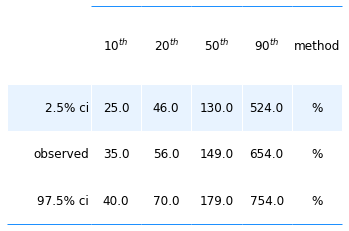

In [5]:
# bootstrap percentile confidence intervals
# the number of reps
n=5000

# keep the observed values
observed_median = dt_all[unit_label].median()
observed_tenth = dt_all[unit_label].quantile(.15)

quantiles = [.1, .2, .5, .9]
q_vals = {x:dt_all[unit_label].quantile(x) for x in quantiles}

the_cis = {}

for a_rank in quantiles:
    # place to keep the results from each resample

    # for the median
    sim_medians = []

    # for the tenth percentile
    sim_ten = []
    for element in np.arange(n):
        less = dt_all[unit_label].sample(n=len(dt_all), replace=True)    
        the_10th = less.quantile(a_rank)
        sim_ten.append(the_10th)
    # get the upper and lower range of the test statistic disrtribution:
    a_min = np.percentile(sim_ten, 2.5)
    a_max = np.percentile(sim_ten, 97.5)
    
    # add the observed value and update the dict
    the_cis.update({F"{int(a_rank*100)}":{'2.5% ci':a_min, 'observed': q_vals[a_rank], '97.5% ci': a_max}})

# make df
p_cis = pd.DataFrame(the_cis)
p_cis = p_cis.round(2)
p_cis['b-method'] = '%'
p_cis.reset_index(inplace=True)

fig, axs = plt.subplots()

data = p_cis.values
ut.hide_spines_ticks_grids(axs)

collabels = ["$" + F"{x}" +"^{th}$" for x in p_cis.columns[:-1]]
collabels.append('method')

the_first_table_data = axs.table(data, colLabels=collabels, colWidths=[.25,*[.15]*5], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data,collabels, a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.close()

*Confidence intervals calculated using the BCa bootstrap method*

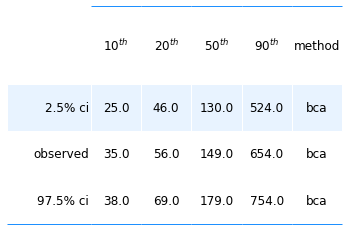

In [6]:
# this code was modified from this source:
# http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/recitations/bootstrapping.html
# if you want to get the confidence interval around another point estimate use np.percentile
# and add the percentile value as a parameter

def draw_bs_sample(data):
    """Draw a bootstrap sample from a 1D data set."""
    return np.random.choice(data, size=len(data))

def compute_jackknife_reps(data, statfunction=None, stat_param=False):
    '''Returns jackknife resampled replicates for the given data and statistical function'''
    # Set up empty array to store jackknife replicates
    jack_reps = np.empty(len(data))

    # For each observation in the dataset, compute the statistical function on the sample
    # with that observation removed
    for i in range(len(data)):
        jack_sample = np.delete(data, i)
        if not stat_param:
            jack_reps[i] = statfunction(jack_sample)
        else:
            jack_reps[i] = statfunction(jack_sample, stat_param)          
        
    return jack_reps


def compute_a(jack_reps):
    '''Returns the acceleration constant a'''

    mean = np.mean(jack_reps)
    try:
        a = sum([(x**-(i+1)- (mean**-(i+1)))**3 for i,x in enumerate(jack_reps)])
        b = sum([(x**-(i+1)-mean-(i+1))**2 for i,x in enumerate(jack_reps)])
        c = 6*(b**(3/2))
        data = a/c
    except:
        print(mean)
    return data


def bootstrap_replicates(data, n_reps=1000, statfunction=None, stat_param=False):
    '''Computes n_reps number of bootstrap replicates for given data and statistical function'''
    boot_reps = np.empty(n_reps)
    for i in range(n_reps):
        if not stat_param:
            boot_reps[i] = statfunction(draw_bs_sample(data))
        else:
            boot_reps[i] = statfunction(draw_bs_sample(data), stat_param)     
        
    return boot_reps


def compute_z0(data, boot_reps, statfunction=None, stat_param=False):
    '''Computes z0 for given data and statistical function'''
    if not stat_param:
        s = statfunction(data)
    else:
        s = statfunction(data, stat_param)
    return stats.norm.ppf(np.sum(boot_reps < s) / len(boot_reps))


def compute_bca_ci(data, alpha_level, n_reps=1000, statfunction=None, stat_param=False):
    '''Returns BCa confidence interval for given data at given alpha level'''
    # Compute bootstrap and jackknife replicates
    boot_reps = bootstrap_replicates(data, n_reps, statfunction=statfunction, stat_param=stat_param)
    jack_reps = compute_jackknife_reps(data, statfunction=statfunction, stat_param=stat_param)

    # Compute a and z0
    a = compute_a(jack_reps)
    z0 = compute_z0(data, boot_reps, statfunction=statfunction, stat_param=stat_param)

    # Compute confidence interval indices
    alphas = np.array([alpha_level/2., 1-alpha_level/2.])
    zs = z0 + stats.norm.ppf(alphas).reshape(alphas.shape+(1,)*z0.ndim)
    avals = stats.norm.cdf(z0 + zs/(1-a*zs))
    ints = np.round((len(boot_reps)-1)*avals)
    ints = np.nan_to_num(ints).astype('int')

    # Compute confidence interval
    boot_reps = np.sort(boot_reps)
    ci_low = boot_reps[ints[0]]
    ci_high = boot_reps[ints[1]]
    return (ci_low, ci_high)

the_bcas = {}
for a_rank in quantiles:
    an_int = int(a_rank*100)
    a_result = compute_bca_ci(dt_all[unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=an_int)
    observed = np.percentile(dt_all[unit_label].to_numpy(), an_int)
    the_bcas.update({F"{int(a_rank*100)}":{'2.5% ci':a_result[0], 'observed': observed, '97.5% ci': a_result[1]}})

bca_cis = pd.DataFrame(the_bcas)
bca_cis['b-method'] = 'bca'
bcas = bca_cis.reset_index()

fig, axs = plt.subplots()

data = bcas.values
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data, colLabels=collabels, colWidths=[.25,*[.15]*5], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data,collabels, a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.close()

### Baseline values

For this set of data the differences between the CIs calculated the BCa method or the percentile method is minimum. The BCa method will be used to report the baseline values and CIs.

#### Baseline median value of all survey results

Considering only surveys with a length greater than 10 meters and excluding objects less than 2.5cm, **the median survey result of all data was 149p/100m with a CI of 130p/100m - 179p/100m**. The reported baseline median value for the EU was 133p/100m, within the range of the CI of the IQAASL survey results. While the median value may be greater in Switzerland the mean value from the EU study is 504p/100m versus 290p/100m in Switzerland.{cite}`eubaselines`

Suggesting that the higher extreme values were more likely in marine environment, but the expected median value from both data sets is similar.

#### Baseline median and CI per survey area

There were four survey areas in the IQAASL, 3 of which had more than 40 samples durring the SP. 

*The median and the 95% confidence interval of the Linth, Aare and Rhône survey areas. The Ticino survey area is not included for lack of a sufficient quantity of surveys.*

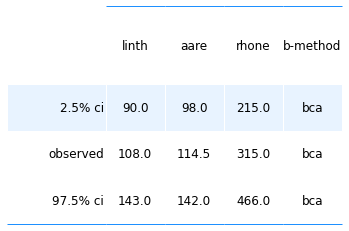

In [7]:
bassins = ["linth", "aare", "rhone"]
the_sas = {}
for a_bassin in bassins:
    an_int = int(a_rank*100)
    a_result = compute_bca_ci(dt_all[dt_all.river_bassin == a_bassin][unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=50)
    observed = np.percentile(dt_all[dt_all.river_bassin == a_bassin][unit_label].to_numpy(), 50)
    the_sas.update({a_bassin:{'2.5% ci':a_result[0], 'observed': observed, '97.5% ci': a_result[1]}})

sas = pd.DataFrame(the_sas)
sas['b-method'] = 'bca'
sas = sas.reset_index()

fig, axs = plt.subplots()

data = sas.values
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data, colLabels=sas.columns, colWidths=[.25,*[.15]*5], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data,sas.columns, a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.close()

## Extreme values

As was noted earlier, extreme values (EVs) or outliers are not excluded from the data when calculating baselines or CIs. However, identifying EVs and where and when they occur is an essential part of the monitoring process.

The occurrence of extreme values can influence the average of the data and the interpretation of survey results. According to the JRC report:

>  The methodology for the identification of extreme values can be either expert judgement, or be based on statistical and modelling approaches, such as the application of Tukey’s box plots to detect potential outliers. For skewed distributions, the adjusted box plot is more appropriate. {cite}`eubaselines`

### Defining extreme values

The references give no guidance as to the numerical value of an EV. Contrary to the target value of 20p/100m or the $15^{th}$ percentile, the definition of an EV is left to the person interpreting the data. The upper limit of Tukeys boxplots (un adjusted) is $\approx 90^{th}$ percentile of the data. This method is compatible with the assessment metric and boxplots are fairly easy to resolve visually.

#### Adjusted boxplots

Tukey’s boxplot is used to visualize the distribution of a univariate data set. The samples that fall within the first quartile ($Q_1$) and the third quartile ($Q_3$) are considered to be within the innerquartial range (IQR) = $Q_3 - Q_1$. Points out side of the inner quartile range are considered outliers if their value is greater or less than one of two limits:

* lower limit = $Q_1 - (1.5*IQR)$

* upper limit = $Q_3 + (1.5*IQR)$

Adusting the boxplot involves replacing the constant 1.5 with another parameter. This parameter is calculated using a method called the _medcouple_ (MC) and applying the result of that method to the constant 1.5. {cite}`adjbox` {cite}`medcouple` The new calculation looks like this:

* lower limit = $Q_1 - (1.5e^{-4MC}*IQR)$

* upper limit = $Q_3 + (1.5e^{3MC}*IQR)$

The limits are extended or reduced to better match the shape of the data. As a result the upper and lower limits represent a wider range of values, with respect to the percentile ranking, as opposed to the unadjusted version.

*The limit at which a survey is conisdered _extreme_ extends to the 98th percentile when the boxplots are adjusted as opposed to the 90th percentile if the constant is left at 1.5.*

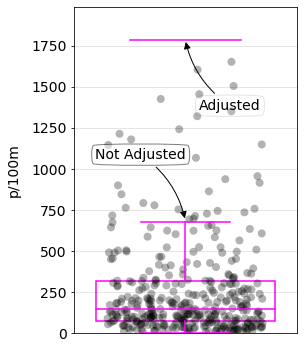

In [8]:
# implementation of medcouple
a_whis = medcouple(dt_all[unit_label].to_numpy())

# get the ecdf 
ecdf = ECDF(dt_all[unit_label].to_numpy())

# quantiles and IQR of the data
q1 = dt_all[unit_label].quantile(0.25)
q3 =dt_all[unit_label].quantile(0.75)
iqr = q3 - q1

# the upper and lower limit of extreme values unadjusted:
limit_lower = q1 - 1.5*iqr
limit_upper = q3 + 1.5*iqr

# the upper and lower limit of extreme values adjusted:
a_fence = q1 - (1.5*(math.exp((-4*a_whis))))*iqr
a_2fence = q3 + (1.5*(math.exp((3*a_whis))))*iqr

fig, ax = plt.subplots(figsize=(4,6))
box_props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'magenta'},
    'medianprops':{'color':'magenta'},
    'whiskerprops':{'color':'magenta'},
    'capprops':{'color':'magenta'}
}

sns.stripplot(data=dt_all, y=unit_label, ax=ax, zorder=1, color='black', jitter=.35, alpha=0.3, s=8)
sns.boxplot(data=dt_all, y=unit_label, ax=ax, zorder=3, orient='v', showfliers=False, **box_props)
ax.axhline(y=a_2fence, xmin=.25, xmax=.75, c='magenta', zorder=3,)
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.tick_params(which='both', axis='both', labelsize=14)
ax.tick_params(which='both', axis='x', bottom=False)

ax.set_ylim(0, a_2fence+200)

ax.annotate("Adjusted",
                  xy=(0, a_2fence), xycoords='data',
                  xytext=(.2,a_2fence-400), textcoords='data',
                  size=14, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w", alpha=0.1),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="black"),)

ax.annotate("Not Adjusted",
                  xy=(0, limit_upper), xycoords='data',
                  xytext=(-.2,limit_upper+400), textcoords='data',
                  size=14, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w",alpha=0.5),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="black"),)
ax.grid(b=True, which='major', axis='y', linestyle='-', linewidth=1, c='black', alpha=.1, zorder=0)
#plt.grid(b=True, )
plt.show()

In [9]:
caption = F"""
*The difference between adjusted and normal boxplots. Adjusted = {int(a_2fence)} {unit_label},  unadjusted = {int(limit_upper)} {unit_label}.*
"""
md(caption)


*The difference between adjusted and normal boxplots. Adjusted = 1784 p/100m,  unadjusted = 687 p/100m.*


Using the adjusted boxplots pushes the extreme value threshold (EVT) to over 1600p/100m. However the unadjusted boxplots fall within the CI of the expected $90{th}$ percentile of the survey data.

#### Modeling

Extreme values can be identified by assuming the data belong to some underlying known statistical distribution. In general count data are assumed to be Poisson distributed or a form very similar. The Poisson distribution assumes that the mean = the variance. The data from IQAASL and beach-litter data in general have a high variance usually greater than the mean.

The negative binomial (NB) distribution does not have such a requirement. The NB is a Poisson distribution with parameter λ, where λ itself is not fixed but a random variable which follows a Gamma distribution. {cite}`cameron` {cite}`wolfram` {cite}`nbinom` 

> The modelling approach for the identification of extreme values is then performed by fitting the NB-distribution to the data by means of maximum likelihood (MLE) and tagging all values in the right tail as potentially extreme values if the probability that they belong to the fitted NB-distribution is less than, e.g. 0.001. {cite}`threshholdeu`

The MLE is one of two recomended methods of _modeling_ or _fitting_ data values to an assummed distribution:

1. Method of moments (MOM)
2. MLE: maximum likelihood estimation

##### Method of moments

The method of moments makes the assumption that the parameters derived from the sample are close or similar to the population parameters. In the case of beach-litter surveys that means the sample median, mean and variance could be considered close
approximations of the actual values if all the beaches on all the lakes and streams were surveyed.

Concretely, the parameters of a probable distribution model are estimated by calculating them from the sample data. This method is easy to apply because most of the parameter calculations for the most common distributions are well known. {cite}`srikanta` {cite}`2020SciPy` {cite}`examplemmoments`

##### Maximum likelihood estimation

MLE is a method of estimating the parameters of a statistical model given some data, in that way it is not different than the MOM. The difference is that in the MOM the model paramters are calculated from the data, in MLE the parameters are chosen by finding the parameters that make the data most likely given the statistical model.

This method is more computationaly involved than the MOM but has some advantages:

* If the model is correctly assumed, the MLE is the most efficient estimator.
* It results in unbiased estimates in larger samples.



*Fitting the data to the underlying NB distribution. The observed survey results are compared to the estimated survey results using the method of moments and maximum likelihood estimation. __Left:__ histogram of results compared to observed data. __Right__ distribution of results compared to obderved data with $90^{th}$ percentile.* 

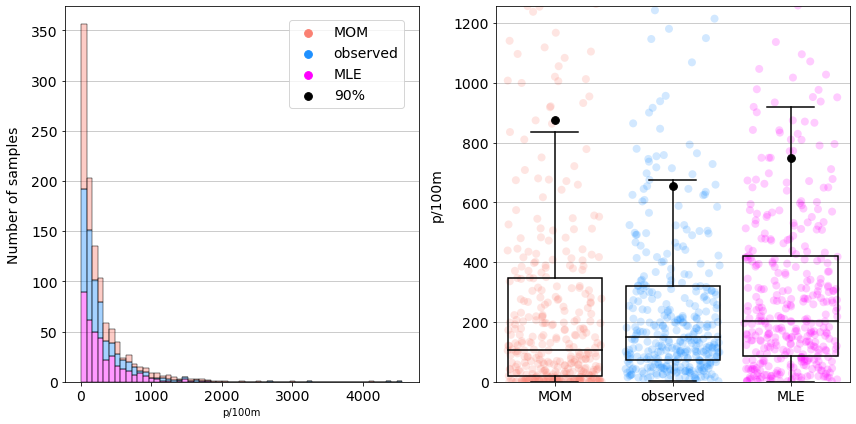

In [10]:
# implementaion of MLE
# https://github.com/pnxenopoulos/negative_binomial/blob/master/negative_binomial/core.py

def r_derv(r_var, vec):
    ''' Function that represents the derivative of the negbinomial likelihood
    '''

    total_sum = 0
    obs_mean = np.mean(vec)  # Save the mean of the data
    n_pop = float(len(vec))  # Save the length of the vector, n_pop

    for obs in vec:
        total_sum += digamma(obs + r_var)

    total_sum -= n_pop*digamma(r_var)
    total_sum += n_pop*math.log(r_var / (r_var + obs_mean))

    return total_sum

def p_equa(r_var, vec):
    ''' Function that represents the equation for p in the negbin likelihood
     '''
    data_sum = sum(vec)
    n_pop = float(len(vec))
    p_var = 1 - (data_sum / (n_pop * r_var + data_sum))
    return p_var

def neg_bin_fit(vec, init=0.0001):
    ''' Function to fit negative binomial to data
    vec: the data vector used to fit the negative binomial distribution
   
    '''
    est_r = newton(r_derv, init, args=(vec,))
    est_p = p_equa(est_r, vec)
    return est_r, est_p

# the data to model
vals = dt_all[unit_label].to_numpy()

# the variance
var = np.var(vals)

# the average
mean = np.mean(vals)

# dispersion
p = (mean/var)
n = (mean**2/(var-mean))

# implementation of method of moments
r = stats.nbinom.rvs(n,p, size=len(vals))

# format data for charting
df = pd.DataFrame({unit_label:vals, 'group':'observed'})
df = df.append(pd.DataFrame({unit_label:r, 'group':'MOM'}))

scp = df[df.group == 'MOM'][unit_label].to_numpy()
obs = df[df.group == 'observed'][unit_label].to_numpy()

scpsx = [{unit_label:x, 'model':'MOM'} for x in scp]
obsx = [{unit_label:x, 'model':'observed'} for x in obs]

# ! implementation of MLE
estimated_r, estimated_p = neg_bin_fit(obs, init = 0.0001)

# ! use the MLE estimators to generate data
som_data = stats.nbinom.rvs(estimated_r, estimated_p, size=len(dt_all))
som_datax = pd.DataFrame([{unit_label:x, 'model':'MLE'}  for x in som_data])

# combined the different results in to one df
data = pd.concat([pd.DataFrame(scpsx), pd.DataFrame(obsx), pd.DataFrame(som_datax)])

# the 90th
ev = data.groupby('model', as_index=False)[unit_label].quantile(.9)
xval={'MOM':0, 'observed':1, 'MLE':2}
ev['x'] = ev.model.map(lambda x: xval[x])
box_palette = {'MOM':'salmon', 'MLE':'magenta', 'observed':'dodgerblue'}

fig, axs = plt.subplots(1,2, figsize=(12,6))

ax=axs[0]
axone=axs[1]

bw=80

sns.histplot(data=data, x=unit_label, ax=ax, hue='model', zorder=2, palette=box_palette, binwidth=bw, element='bars', multiple='stack', alpha=0.4)

box_props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}


sns.boxplot(data=data, x='model', y=unit_label, ax=axone, zorder=5, palette=box_palette, showfliers=False, dodge=False, **box_props)
sns.stripplot(data=data, x='model', y=unit_label, hue='model', zorder=0,palette=box_palette, ax=axone, s=8, alpha=0.2, dodge=False, jitter=0.4)
axone.scatter(x=ev.x.values, y=ev[unit_label].values, label="90%", color='black', s=60)
axone.set_ylim(0,np.percentile(r, 95))
ax.get_legend().remove()
ax.set_ylabel("Number of samples", **ck.xlab_k14)
axone.set_ylabel(unit_label, **ck.xlab_k14)

handles, labels = axone.get_legend_handles_labels()
axone.get_legend().remove()
h3=handles[:3]
hlast= handles[-1:]
axone.set_xlabel("")
axone.tick_params(which='both', axis='both', labelsize=14)
ax.tick_params(which='both', axis='both', labelsize=14)
l3 = labels[:3]
llast = labels[-1:]

ax.grid(b=True, which='major', axis='y', linestyle='-', linewidth=1, c='black', alpha=.2, zorder=0)
axone.grid(b=True, which='major', axis='y', linestyle='-', linewidth=1, c='black', alpha=.2, zorder=0)


fig.legend([*h3, *hlast], [*l3, *llast], bbox_to_anchor=(.48, .96), loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
evx = ev.set_index('model')

pnt =  F"""*90%: MLE={evx.loc['MLE'][unit_label]},  Observed:{evx.loc['observed'][unit_label]},  MOM:{evx.loc['MOM'][unit_label]}*"""
md(pnt)

*90%: MLE=749.0,  Observed:654.0,  MOM:874.0*

## Implementation

The proposed, assessment metrics and evaluation methods for beach litter survey results are similar and compatible with the methods previously implemented in Switzerland. This first analysis has shown that:

1. Methods proposed by the EU to monitor litter are applicable in Switzerland
2. Confidence intervals and baselines can be calculated for different survey areas
3. Aggregated results can be compared between regions

Once the BV for a survey area is calculated all samples that are conducted within that survey area can be compared directly to it. It is the case in 2020 - 2021 that the survey areas in Switzerland have different median baselines. This situation is analogous to the EU with respect to the differences between different regions and administrative areas of the continent.

By applying the proposed methods to the current results from IQAASL the objects of concern can be identified for each survey area.

*Comparing the baseline values of the most common objects. All survey areas 2020 - 2021. The Ticino/Cerisio survey area has less than 100 surveys. __units= p/50m__*

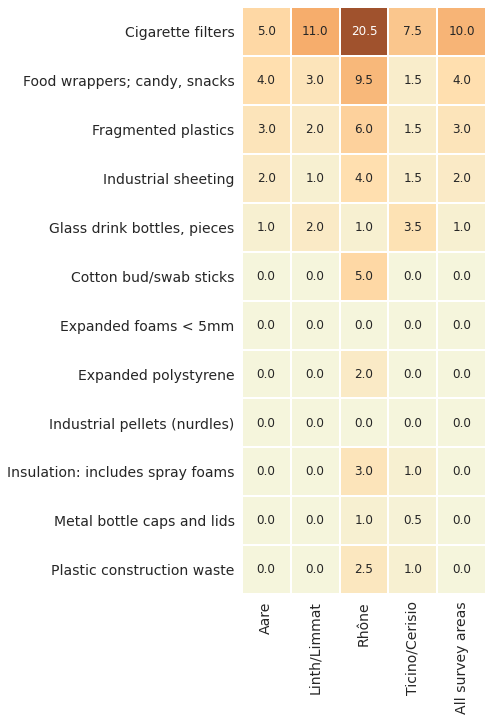

In [12]:
bassin_map = PILImage.open("resources/images/all_survey_areas_mcommon.png")
output = io.BytesIO()
bassin_map.thumbnail((800, 1200))
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
md(html)

The expected median value and the median value of the most common objects is higher in the Rhône survey area. When the median value is used the BV also reveals that 7/12 most common objects were found in less than 50% of the surveys nationally, those with a median value of zero.

The method can be scaled vertically giving a more detailed view of a survey area. The method of calculation remains the same therefore comparisons are valid from the lake to the national level.

*Comparing the baseline values of the most common objects. Aare survey area lakes and rivers 2020 - 2021. __units= p/50m__*

*Locations with more than 30 surveys: Bielersee, Neuenburgersee and Thunersee*

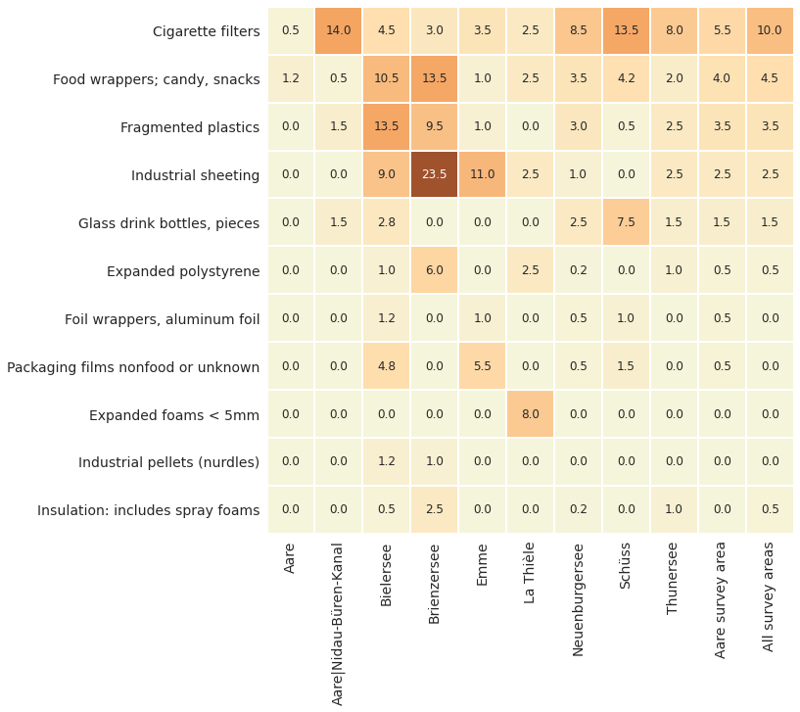

In [13]:
bassin_map = PILImage.open("resources/images/example_implementation.png")
output = io.BytesIO()
bassin_map.thumbnail((800, 800))
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
md(html)

The recommended minimum number of surveys (40) per sampling period is to ensure that BV calculations are based on a sufficient number of samples, this is important because of the high variability of beach litter surveys. 

The sampling period for IQAASL was April through May 2020 - 2021. With respect to the minimum number of samples there are three baseline values for the Aare survey area:

1. Bielersee
2. Neuenburgersee
3. The Aare survey area

For assessment purposes this means that one sample can serve as a spot assessment and the results can be compared to any of the regional baselines directly, providing instant feedback. This type of assessment simplifies the process and empowers local stakeholders to carry out independent assessments, draw conclusions and define mitigation strategies based on the results of the established BV for the survey area.

In the previous examples no threshold values or extreme values are indicated. Values greater than zero are the expected median amount of that object for every measured unit, a zero value indicates that the object was found in less than 50% of the surveys. The percentile ranking for a particular object can be inferred by reading the table of values in the horizontal direction.

How meaningful these results are to the assessment of mitigation strategies depends on the number and quality of samples. Stakeholders at the municipal or local level need detailed data about specific objects. While national and international stakeholders tend to use broader aggregated groups.

The quality of the data is directly related to the training and support of the surveyors. The identification process is long at first and many objects are not familiar to the _average person_. Encouraging meetings between surveyors and having a core team to assist in the development and training ensures that the surveys are conducted consistently over time.

The monitoring program in Switzerland has managed to keep pace with developments on the continent, there are however many areas of improvement:

1. Defining a standardized reporting method for municipal, cantonal and federal stakeholders
2. Define monitoring or assessment goals
3. Formalize the data repository and the method for implementation at different administrative levels
4. Develop a network of associations that share the responsibility of surveying the territory
5. Develop and implement a formal training program for surveyors
6. Determine, in collaboration with academic partners, ideal sampling scenarios and research needs

Changes in beach-litter survey results are signals, using baseline values helps identify the magnitude of those signals. However, without any context or additional information changes may appear random. Expert judgement includes the ability to place survey results in the context of local events and topography. This capacity of discernment with regards to the data and the environment it was collected in is part of identifying potential sources and priorities.

In [14]:
author = "roger@hammerdirt.ch"
my_message = "Love what you do. \u2764\ufe0f"
md(F"""
<br></br>
**This project was made possible by the Swiss federal office for the environment.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
""")


<br></br>
**This project was made possible by the Swiss federal office for the environment.**<br>

>Love what you do. ❤️<br>

*roger@hammerdirt.ch* pushed the run button on 2021-08-25.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
